In [2]:
!pip install pycausalimpact


/usr/local/lib/python3.12/dist-packages/causalimpact/main.py:603: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data.applymap(np.isreal).values.all():
/usr/local/lib/python3.12/dist-packages/causalimpact/main.py:302: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.mu_sig = (mu[0], sig[0])
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)
/usr/local/lib/python3.12/dist-packages/statsmodels/

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    2244.43            94266.0
Prediction (s.d.)         3642.88 (62.42)    153001.15 (2621.77)
95% CI                    [3528.27, 3772.97] [148187.54, 158464.67]

Absolute effect (s.d.)    -1398.46 (62.42)   -58735.15 (2621.77)
95% CI                    [-1528.54, -1283.85][-64198.67, -53921.54]

Relative effect (s.d.)    -38.39% (1.71%)    -38.39% (1.71%)
95% CI                    [-41.96%, -35.24%] [-41.96%, -35.24%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 2244.43. By contrast, in the absence of an
intervention, we would have expected an average response of 3642.88.
The 95% interval of this counterfactual prediction is [3528.27, 3772.97].
S

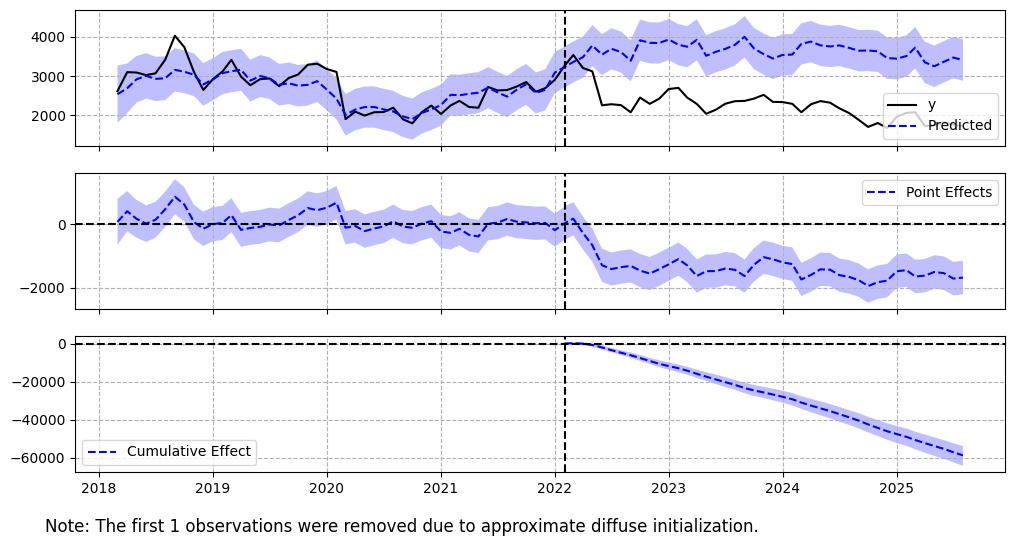

In [4]:
# ===============================
# 0️⃣ Paquetes
# ===============================
import pandas as pd
import numpy as np
import re
from causalimpact import CausalImpact
import matplotlib.pyplot as plt
import seaborn as sns

# ===============================
# 1️⃣ Leer CSV correctamente
# ===============================
datos_raw = pd.read_csv(
    "/home/Datos históricos de Ecopetrol (EC)1.csv",
    sep=";",
    decimal=",",
    header=0,
    dtype=str
)

# Quitar la primera fila de nombres repetidos (si existe)
datos_raw = datos_raw.iloc[1:, :]

# ===============================
# 2️⃣ Funciones para extraer precios, recordar que hubo que armar la csv por lo
#     que hay que organizarla bien
# ===============================
def extraer_precio_ecopetrol(col):
    match = re.search(r'\d{1,3}(?:\.\d{3})*,\d+', col)
    if match:
        val = match.group(0).replace(".", "").replace(",", ".")
        return float(val)
    else:
        return np.nan

def extraer_precio_brent_syp(col):
    match = re.search(r'\d+,\d+', col)
    if match:
        return float(match.group(0).replace(",", "."))
    else:
        return np.nan

def extraer_precio_exxon(col):
    match = re.search(r'\d+\.\d+', col)
    if match:
        return float(match.group(0))
    else:
        return np.nan

# ===============================
# 3️⃣ Crear DataFrame con precios
# ===============================
ci_data = pd.DataFrame({
    "Fecha": pd.to_datetime(datos_raw["ecopetrol"].str.extract(r'(\d{2}\.\d{2}\.\d{4})')[0], format="%d.%m.%Y"),
    "Ecopetrol": datos_raw["ecopetrol"].apply(extraer_precio_ecopetrol),
    "Brent": datos_raw["brent"].apply(extraer_precio_brent_syp),
    "SYP": datos_raw["syp"].apply(extraer_precio_brent_syp),
    "Exxon": datos_raw["exxon"].apply(extraer_precio_exxon)
})

# ===============================
# 4️⃣ Ordenar por fecha, los primeros datos son los de 2025 porque hay que reordenar
# ===============================
ci_data = ci_data.sort_values("Fecha").reset_index(drop=True)

# ===============================
# 5️⃣ Convertir a series de tiempo
# ===============================
ci_data_ts = ci_data.set_index("Fecha")

# ===============================
# 6️⃣ Definir periodos pre y post evento
# se puede modificar el periodo, recordar que el modelo es sensible
# ===============================
pre_period = [pd.Timestamp("2018-02-01"), pd.Timestamp("2022-02-01")]
post_period = [pd.Timestamp("2022-03-01"), pd.Timestamp("2025-08-01")]

# ===============================
# 7️⃣ Ejecutar CausalImpact
# ===============================
ci = CausalImpact(
    data=ci_data_ts,
    pre_period=pre_period,
    post_period=post_period
)

# ===============================
# 8️⃣ Resumen y gráfica
# ===============================
print(ci.summary())
print(ci.summary(output='report'))
ci.plot(figsize=(12,6))

# ===============================


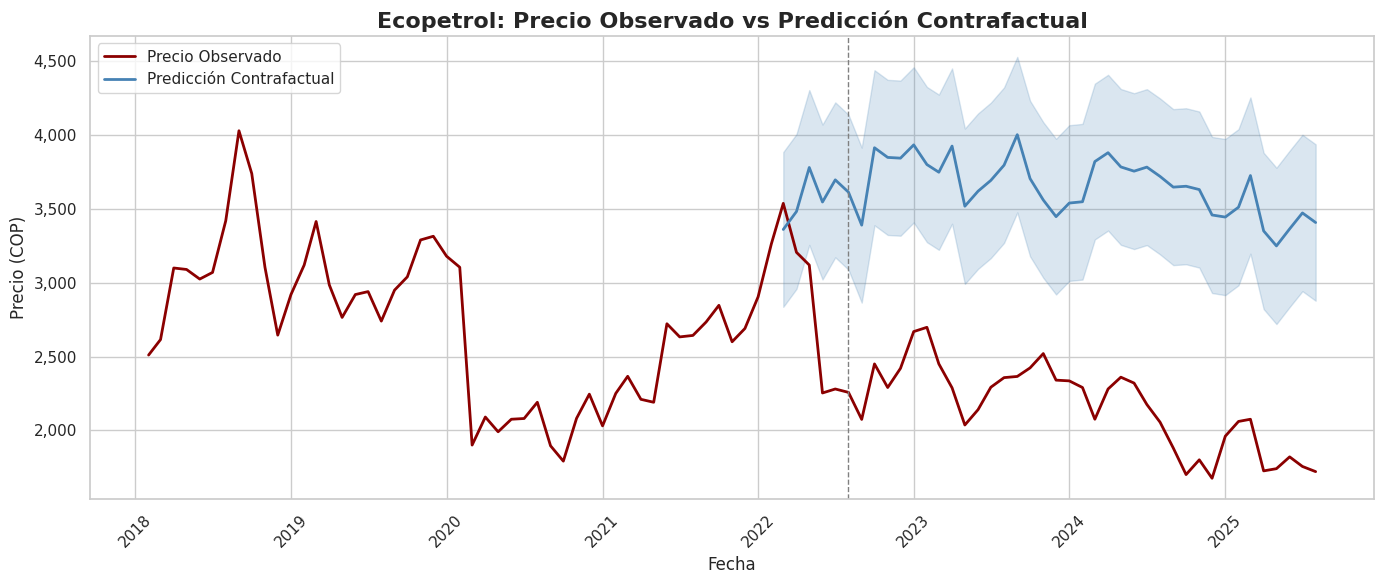

In [5]:
# Filtrar datos usados en el modelo
ci_data_filtered = ci_data_ts.loc['2018-02-01':'2025-08-01'].copy()

# Extraer columnas de inferencia
plot_df = ci.inferences.copy()
plot_df['Fecha'] = ci_data_filtered.index[:len(plot_df)]  # asegurarse que coincida

# Elegir columnas correctas según tu output
plot_df['Precio Observado'] = ci_data_filtered['Ecopetrol'].values[:len(plot_df)]
plot_df.rename(columns={
    'post_preds': 'Predicción Contrafactual',
    'post_preds_lower': 'IC Inferior',
    'post_preds_upper': 'IC Superior'
}, inplace=True)

# ===============================
# Gráfico
# ===============================
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(14,6))

# Precio observado
plt.plot(plot_df['Fecha'], plot_df['Precio Observado'],
         color='darkred', label='Precio Observado', linewidth=2)

# Predicción contrafactual
plt.plot(plot_df['Fecha'], plot_df['Predicción Contrafactual'],
         color='steelblue', label='Predicción Contrafactual', linewidth=2)

# Intervalo de credibilidad
plt.fill_between(plot_df['Fecha'],
                 plot_df['IC Inferior'],
                 plot_df['IC Superior'],
                 color='steelblue', alpha=0.2)

# Línea vertical de evento
plt.axvline(x=pd.Timestamp("2022-08-01"), color='gray', linestyle='--', linewidth=1)

# Etiquetas y formato
plt.title("Ecopetrol: Precio Observado vs Predicción Contrafactual", fontsize=16, fontweight='bold')
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Precio (COP)", fontsize=12)
plt.legend()
plt.xticks(rotation=45)

# Formato de eje Y con separador de miles
import matplotlib.ticker as mtick
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

plt.tight_layout()
plt.show()





Matriz de correlación (todo el periodo):
           Ecopetrol     Brent       SYP     Exxon
Ecopetrol   1.000000  0.484872  0.069957 -0.144446
Brent       0.484872  1.000000  0.533696  0.551750
SYP         0.069957  0.533696  1.000000  0.485670
Exxon      -0.144446  0.551750  0.485670  1.000000


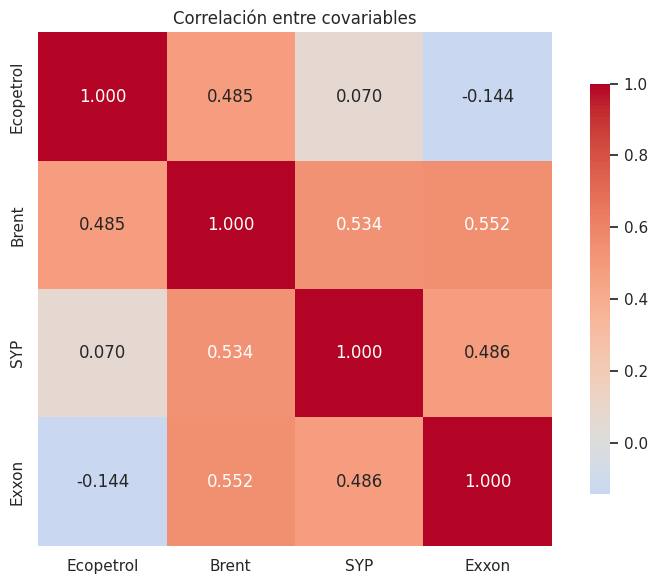


Matriz de correlación (pre-evento):
           Ecopetrol     Brent       SYP     Exxon
Ecopetrol   1.000000  0.524638 -0.157326  0.736210
Brent       0.524638  1.000000  0.467795  0.789197
SYP        -0.157326  0.467795  1.000000 -0.095303
Exxon       0.736210  0.789197 -0.095303  1.000000


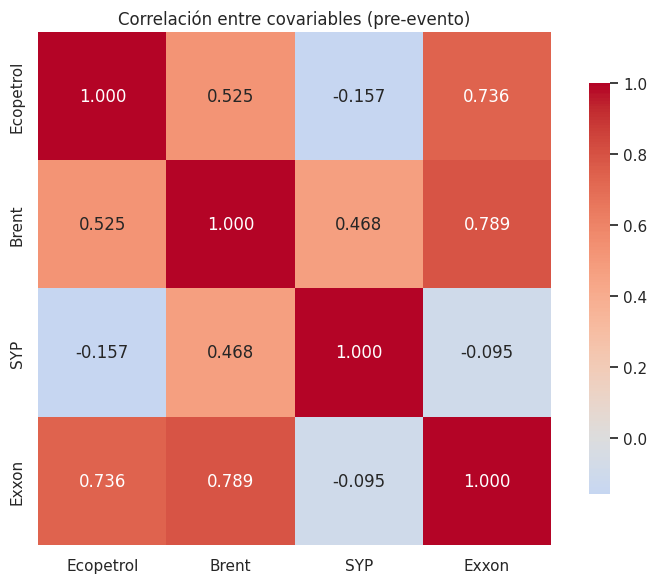

AttributeError: 'UnobservedComponents' object has no attribute 'bsts_model'

In [7]:
# ===============================
# 5.1️⃣ Revisar correlaciones generales
# ===============================
import seaborn as sns
import matplotlib.pyplot as plt

# Seleccionar solo las variables numéricas
vars_numeric = ci_data[["Ecopetrol", "Brent", "SYP", "Exxon"]]

# Matriz de correlación completa
cor_matrix = vars_numeric.corr(method="pearson")
print("Matriz de correlación (todo el periodo):")
print(cor_matrix)

# Visualización
plt.figure(figsize=(8, 6))
sns.heatmap(cor_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f', cbar_kws={"shrink": .8})
plt.title("Correlación entre covariables")
plt.tight_layout()
plt.show()

# ===============================
# 5.2️⃣ Correlación solo en periodo pre-evento
# ===============================
pre_start = pd.Timestamp("2018-02-01")
pre_end = pd.Timestamp("2022-07-31")

# Filtrar datos en periodo pre-evento
ci_pre = ci_data[(ci_data["Fecha"] >= pre_start) & (ci_data["Fecha"] <= pre_end)]
vars_numeric_pre = ci_pre[["Ecopetrol", "Brent", "SYP", "Exxon"]]

# Matriz de correlación en pre-evento
cor_matrix_pre = vars_numeric_pre.corr()
print("\nMatriz de correlación (pre-evento):")
print(cor_matrix_pre)

# Visualización
plt.figure(figsize=(8, 6))
sns.heatmap(cor_matrix_pre, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f', cbar_kws={"shrink": .8})
plt.title("Correlación entre covariables (pre-evento)")
plt.tight_layout()
plt.show()
